In [1]:
# Goal: classify images CATS vs DOGS

In [2]:
# 1. Get the dataset from the Kaggle competition
# https://www.kaggle.com/c/dogs-vs-cats/data
# Download all e un-zippa
    
    

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
%matplotlib inline

In [4]:
## No GPU in my case

In [5]:
# Data preparation: Sostanzialmente prenditi solo poche immagini per giocare.

# if os.path.isdir("data/dogs-vs-cats/train/dog") is False:
#     os.makedirs("data/dogs-vs-cats/train/dog")
#     os.makedirs("data/dogs-vs-cats/train/cat")
#     os.makedirs("data/dogs-vs-cats/valid/dog")
#     os.makedirs("data/dogs-vs-cats/valid/cat")
#     os.makedirs("data/dogs-vs-cats/test/dog")
#     os.makedirs("data/dogs-vs-cats/test/cat")
    
#     # il sample è moooolto grande, per questo esercizietto, usane 100 come train, 200 come valid, 100 come test
#     for c in random.sample(glob.glob("cat*"), 500):
#         shutil.move(c,"train/cat")
#     for c in random.sample(glob.glob("dog*"), 500):
#         shutil.move(c,"train/dog")
#     for c in random.sample(glob.glob("cat*"), 100):
#         shutil.move(c,"valid/cat")
#     for c in random.sample(glob.glob("dog*"), 100):
#         shutil.move(c,"valid/dog")
#     for c in random.sample(glob.glob("cat*"), 50):
#         shutil.move(c,"test/cat")
#     for c in random.sample(glob.glob("cat*"), 50):
#         shutil.move(c,"test/dog")

In [6]:
train_path = "data/dogs-vs-cats/train/"
valid_path = "data/dogs-vs-cats/valid"
test_path = "data/dogs-vs-cats/test"

In [10]:
## Put the images in a format that Keras actually likes (keras generators)
## Qua in sintesti dico: le varie immagini sono una diversa dall'altra:
## Vedi che devi fare, le voglio tutte in formato 224, 224
## Sostanzialmente sta facendo il preprocessing come è fatto nella vgg16
## Nell'immagine, ogni pixel ha, se ho capito bene (R,G,B) una tripletta di rosso, verde, blu
## vgg16 prende il training set, calcola la media del rosso, R_, media del verde, G_ e del blu B_
## e dopo, immagine per immagine, (R,G,B) --> (R - R_, G -G_, B-B_) 
## Quindi i colori dopo il pre-processing sono un po' strani all'occhio umano
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
.flow_from_directory(directory=train_path, target_size=(224,224), classes=["cat","dog"], batch_size=10)

valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
.flow_from_directory(directory=valid_path, target_size=(224,224), classes=["cat","dog"], batch_size=10)

test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
.flow_from_directory(directory=test_path, target_size=(224,224), classes=["cat","dog"], batch_size=10, shuffle=False)

assert train_batches.n == 1000
assert valid_batches.n == 200
assert test_batches.n == 100

Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

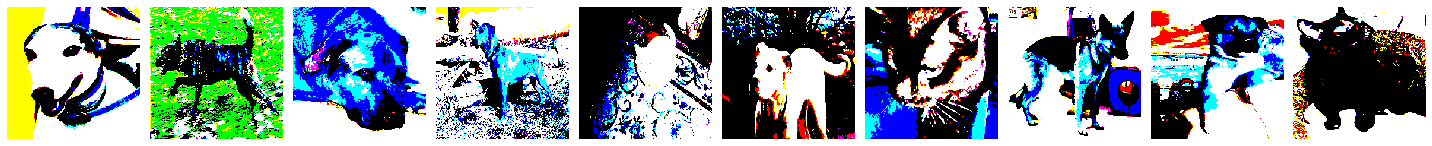

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]


In [15]:
## Guardiamoci queste immagini pre-processate va!
# imgs, labels = next(train_batches) #questo prende una "fila" per volta

# ## plot images in a grid: 1 row, 10 cols
# def plotImages(images_arr):
#     fig, axes = plt.subplots(1, 10, figsize=(20,20))
#     axes = axes.flatten()
#     for img, ax in zip(images_arr, axes):
#         ax.imshow(img)
#         ax.axis("off")
#     plt.tight_layout()
#     plt.show()
# plotImages(imgs)
# print(labels)


In [18]:
## Build the model

model = Sequential([
    #input_shape=(224,224,3) --> (224,224) è il target_size, poi 3 sono i colori
    #padding=same means No padding --> the images is not reduced
    Conv2D(filters=32, kernel_size=(3,3), activation="relu", padding = "same", input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2,2), strides=2),
    Conv2D(filters=64, kernel_size=(3,3), activation="relu", padding="same"),
    MaxPool2D(pool_size=(2,2), strides=2),
    Flatten(),
    Dense(units=2, activation="softmax"),
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 200704)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 401410    
Total params: 420,802
Trainable params: 420,802
Non-trainable params: 0
________________________________________________

In [22]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=['accuracy'])

## OPPURE, visto che di fatto ho 2 categorie, potrei usare loss=binary_crossentropy, MA
## l'ultimo layer del modello deve avere un output solo invece che 2, e invece che softmax devi usare sigmoid
## model.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=['accuracy'])

model.fit(x=train_batches, validation_data=valid_batches, epochs=10, verbose=2)

Epoch 1/10
100/100 - 25s - loss: 20.3704 - accuracy: 0.5570 - val_loss: 3.8570 - val_accuracy: 0.5900
Epoch 2/10
100/100 - 27s - loss: 2.8141 - accuracy: 0.7390 - val_loss: 4.0080 - val_accuracy: 0.6000
Epoch 3/10
100/100 - 26s - loss: 1.2964 - accuracy: 0.8220 - val_loss: 4.4657 - val_accuracy: 0.5900
Epoch 4/10
100/100 - 26s - loss: 0.2004 - accuracy: 0.9490 - val_loss: 3.4744 - val_accuracy: 0.6400
Epoch 5/10
100/100 - 26s - loss: 0.1116 - accuracy: 0.9710 - val_loss: 2.8384 - val_accuracy: 0.6200
Epoch 6/10
100/100 - 27s - loss: 0.0191 - accuracy: 0.9940 - val_loss: 2.8656 - val_accuracy: 0.6450
Epoch 7/10
100/100 - 26s - loss: 0.0017 - accuracy: 1.0000 - val_loss: 2.8085 - val_accuracy: 0.6400
Epoch 8/10
100/100 - 25s - loss: 4.9616e-04 - accuracy: 1.0000 - val_loss: 2.7969 - val_accuracy: 0.6450
Epoch 9/10
100/100 - 25s - loss: 3.7957e-04 - accuracy: 1.0000 - val_loss: 2.8141 - val_accuracy: 0.6400
Epoch 10/10
100/100 - 25s - loss: 2.9925e-04 - accuracy: 1.0000 - val_loss: 2.8007

In [23]:
test_batches.classes 
## Il test set non è shuffled, quindi i primi N sono gatti, i secondi N sono tutti cani

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [26]:
predictions = model.predict(x=test_batches, verbose=0)
np.round(predictions)
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))
print(cm)

[[35 15]
 [34 16]]
